In [1]:
import csv
import os
from os import listdir  
os.environ["CUDA_VISIBLE_DIVICES"]=''

import pandas as pd
import numpy as np
from scipy.stats import kde

import tensorflow as tf
from tensorflow import keras
from keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector, Masking, Embedding
from keras.models import Model
from keras import regularizers
from keras.preprocessing.sequence import pad_sequences

import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt
%matplotlib inline

# set random seed
np.random.seed(10)
tf.random.set_seed(10)

In [2]:
# users: list of user names
# usecols: list of columns

def load_dataset(users, usecols):
    data_list = []
    
    for user in users:
        for file in listdir('./log_segment_info/'+user):
            log_name = file.split("_")[0]

            # log{logname}_info.csv 파일을 load
            log_csv_name= './log_segment_info/'+user+"/"+file
            
            # log 파일이 아니면 스킵
            if('segment' not in file):
                continue

            if os.path.isfile(log_csv_name):
                csv = pd.read_csv(log_csv_name, usecols=usecols)
                # log의 길이가 0이면 스킵
                if len(csv) == 0:
                    print("log length is 0")
                    continue

                # segment matching이 실패한 행 제외
                #csv = csv[csv['seg_id'].notnull()]

                data_list.append(csv)
            else:
                print("no log info")

    return data_list

In [6]:
def find_bins(observations, width):
    minimmum = np.min(observations)
    maximmum = np.max(observations)
    bound_min = -1.0 * (minimmum % width - minimmum)
    bound_max = maximmum - maximmum % width + width
    n = int((bound_max - bound_min) / width) + 1
    bins = np.linspace(bound_min, bound_max, n)
    return bins


def plot_distribution(data_list):
    data_len_list = []
    
    # segment 길이 추출
    for data in data_list:
        data_len_list.append(len(data))
    
    
    # plot matplotlib histogram
    bins = find_bins(data_len_list, 200.0)
    plt.hist(data_len_list, bins=bins)
    plt.show()
    
    
    # plot seaborn histogram
    sns.histplot(data_len_list, kde=True, stat="count", linewidth=0, bins=bins)
    plt.show()
    
    
    # 가우시안 커널 밀도 추정
    density = kde.gaussian_kde(data_len_list)
    x = np.linspace(0, 9000, 300)
    y = density(x)

    plt.plot(x, y)
    plt.title("Density Plot of the data")
    plt.show()

In [4]:
def add_padding(data_list, max_length):
    padded_data_list = pad_sequences(data_list, padding='post', maxlen=max_length, dtype='float64')
    return padded_data_list

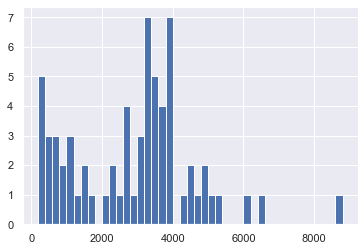

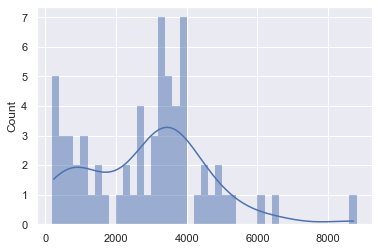

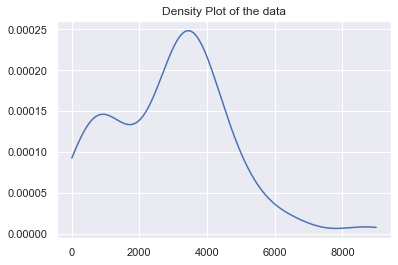

RangeIndex(start=0, stop=1407, step=1)

In [7]:
# 사용자 load, 사용할 column 선택
users = ['0mnEB226qqgHE79KLEfxRj6fiEK2',
         '9z6F6ewGNzV4a6z0vpenjZH21Ar1']
usecols = ['mercX', 'mercY']


# dataset 가져오기 (list 안에 dataframe들이 들어있는 형태)
data_list = load_dataset(users, usecols)


# data 길이의 분포 알아보기
plot_distribution(data_list)
max_length = 6400


# 선택된 길이에 맞춰서 padding 수행
padded_data_list = add_padding(data_list, max_length)

data_list[0].index